### Analysis of Vacor-1a probe imaging in iPSC-MNs
- Experiment on 050223. InCarta on 050523. Analysis on 051423.
- Goal: Create a cell-by-cell histogram of average soma fluorescence intensity of the 1a probe.
    1. Is there a vacor dose-dependent increase in 1a probe intensity?
    2. Is the spectral separation between vehicle- and vacor-treated cells enough to gate on for a screen?

In [1]:
# Import modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Provide cell culture plate layout (with experimental conditions) as a dataframe. 
rows = ['A','B','C','D','E','F']
cols = list(range(1,9))
vacor_tx = [0,2,4,6,8,10,15,25]

plate_df = pd.DataFrame(columns = ['Row','Column','Vacor'])

for r in range(len(rows)):
    for c in range(len(cols)):
        new_row = {
            'Row': rows[r],
            'Column': cols[c],
            'Vacor': vacor_tx[c]
        }
        plate_df.loc[len(plate_df)] = new_row

Here is a visual format of the experimental design used for the above dataframe. 
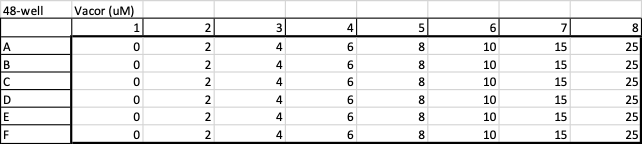

In [17]:
# Get list of all InCarta analysis files from my local directory. Each file is a CSV file type pertaining to each timepoint.
path = "../InCell/InCarta/050223/"
filename_lst = os.listdir(path)

# Read data across timepoints into one dataframe
data_df = pd.DataFrame()
for filename in filename_lst:
    if filename[-3:] == 'csv': # This is to filter out .dstore files
        # Read in file corresponding to one timepoint
        timept_df = pd.read_csv(path + filename)
        # Take only pertinent data columns
        timept_df = timept_df[['Row','Column','Plate ID','Cells Intensity (Cell) wv2']]
        # Merge data dataframe and plate layout dataframe
        timept_df_tidy = pd.merge(
            timept_df, # Take only pertinent data columns
            plate_df,
            on=['Row','Column']
        )
        # Concatenate single timepoint df to full data df
        data_df = pd.concat([data_df,timept_df_tidy])
    else:
        continue

In [23]:
# Convert Plate ID type to numbers (for convenience)
data_df["Plate ID"] = data_df["Plate ID"].apply(lambda x: int(x[:-1]))
data_df

,Row,Column,Plate ID,Cells Intensity (Cell) wv2,Vacor
0,A,1,4,441.606557,0
1,A,1,4,447.428667,0
2,A,1,4,422.383065,0
3,A,1,4,390.462594,0
4,A,1,4,358.643302,0
...,...,...,...,...,...
55699,F,8,6,1005.339161,25
55700,F,8,6,1246.191843,25
55701,F,8,6,1030.626190,25
55702,F,8,6,604.515021,25


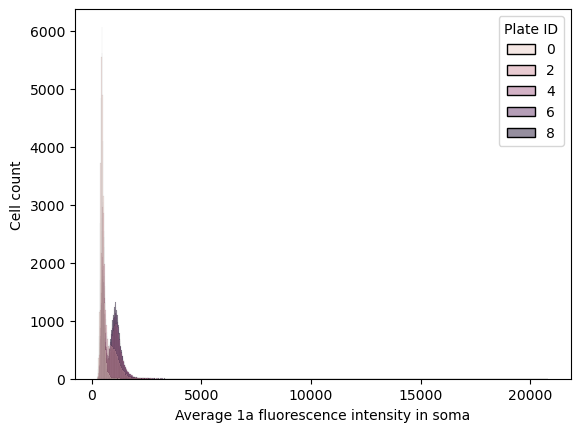

In [26]:
# Global overview of data
# Note: this includes all vacor concentrations within each timepoint
ax = sns.histplot(data = data_df, x = 'Cells Intensity (Cell) wv2', hue="Plate ID")
ax.set(xlabel="Average 1a fluorescence intensity in soma", ylabel="Cell count")
plt.show()

Simulate a FACS by "gating" the top x% of true positive cells, then determine false discovery rate with false positive cells.

In [64]:
# Provide values for simulation
pct = 0.2 
timept = 8
tp_conc = 4
fp_conc = 0

In [65]:
# Get "true positive" cells that will be gated on: vacor 4uM
data_df_true = data_df.loc[(data_df['Plate ID'] == timept) & (data_df['Vacor'] == tp_conc)]
# Determine cutoff for top x% of values
top_idx = int(pct*len(data_df_true))
top_cutoff = np.min(data_df_true.sort_values(by='Cells Intensity (Cell) wv2',ascending=False).head(top_idx)['Cells Intensity (Cell) wv2'])
print("Top {}% index: {} of {}".format(pct*100, top_idx,len(data_df_true)))
print("Top {}% cutoff value: {:0.2f}".format(pct*100, top_cutoff))
print("Sanity check ... Min: {:0.2f}. Max: {:0.2f}.".format(data_df_true['Cells Intensity (Cell) wv2'].min(), data_df_true['Cells Intensity (Cell) wv2'].max()))

# Determine false discovery rate (FP / (FP + TP)): AUC vacor 0uM / (AUC vacor 4uM + AUC vacor 0uM).
data_df_false = data_df.loc[(data_df['Plate ID'] == timept) & (data_df['Vacor'] == fp_conc)]
fp = len(data_df_false[data_df_false['Cells Intensity (Cell) wv2'] > top20_cutoff])
tp = len(data_df_true[data_df_true['Cells Intensity (Cell) wv2'] > top20_cutoff])
print("False discovery rate: {:0.2f}%".format(100*(fp / (fp + tp))))


Top 20.0% index: 1253 of 6267
Top 20.0% cutoff value: 1289.23
Sanity check ... Min: 291.36. Max: 3864.70.
False discovery rate: 3.02%


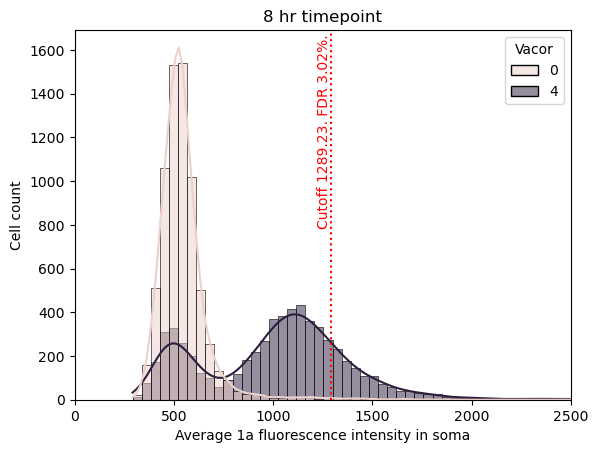

In [67]:
# Snapshot of above cutoff displayed

# Subset dataframe
plt_df = data_df.loc[(data_df['Plate ID'] == timept) & data_df['Vacor'].isin([fp_conc,tp_conc])]

# Plot vehicle vs. vacor conditions by timepoint
ax = sns.histplot(data = plt_df, x = 'Cells Intensity (Cell) wv2', hue="Vacor", kde=True)

# Format plot
ax.set(title="{} hr timepoint".format(timept), xlabel="Average 1a fluorescence intensity in soma", ylabel="Cell count")
ax.axvline(top_cutoff, color = "r",ls=":")
ax.text(top_cutoff, 0.99, 'Cutoff {:0.2f}. FDR {:0.2f}%.'.format(top_cutoff,100*(fp / (fp + tp))), color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())

plt.xlim(0,2500)
plt.show()